# UrbanSound machine learning

* The codes : learned from

- youtube video series "Deep Learning (for audio) using Python" -- using librosa
    https://www.youtube.com/watch?v=m3XbqfIij_Y  and more
    
- towarddatasience -- urbansound
   Part1: https://towardsdatascience.com/urban-sound-classification-part-1-99137c6335f9
   PArt2: https://towardsdatascience.com/urban-sound-classification-part-2-sample-rate-conversion-librosa-ba7bc88f209a
    

In [1]:
# marsys -- music genres, folders-- many files.

import pandas as pd
import os
import librosa
import math
import json
import numpy as np

DATASET_PATH = "../../Sounds/UrbanSound8K"  # in the video, the files are music files
JASON_PATH = "data.json"

In [2]:
metadata = pd.read_csv(f"{DATASET_PATH}/metadata/UrbanSound8K.csv")

In [3]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
filename = "7383-3-0-0.wav"
metadata.loc[metadata["slice_file_name"]==filename]

,slice_file_name,fsID,start,end,salience,fold,classID,class
7660,7383-3-0-0.wav,7383,3.9021,7.9021,1,1,3,dog_bark


In [21]:
metadata.loc[metadata["fold"]==1].head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
64,101415-3-0-2.wav,101415,1.000000,5.000000,1,1,3,dog_bark
65,101415-3-0-3.wav,101415,1.500000,5.500000,1,1,3,dog_bark
66,101415-3-0-8.wav,101415,4.000000,8.000000,1,1,3,dog_bark
105,102106-3-0-0.wav,102106,2.243852,3.884477,2,1,3,dog_bark
106,102305-6-0-0.wav,102305,0.000000,2.611610,1,1,6,gun_shot


In [4]:
metadata.loc[metadata["fold"]==1].nunique()

slice_file_name    873
fsID               134
start              488
end                506
salience             2
fold                 1
classID             10
class               10
dtype: int64

Converted Sample Rate :  22050
Converted Signal min ~ max :  -0.32452014 ~ 0.29852936


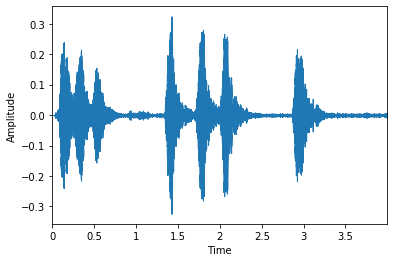

In [13]:
import librosa.display
import matplotlib.pyplot as plt

#waveform,   sr * T => 22050 * 30,  sr=sampling rate
filepath = f"{DATASET_PATH}/audio/fold1/{filename}"
signal, sr = librosa.load(filepath, sr=22050)

print("Converted Sample Rate : ", sr)
print("Converted Signal min ~ max : ", np.min(signal), "~", np.max(signal))

librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

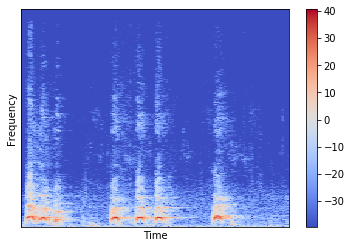

In [18]:
# short time Fourier Transform (stft) --- spectrogram
n_fft = 2048 # number of samples
hop_length = 512 # amount shifting F.T. to right , sliding to right
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)


log_spectrogram = librosa.amplitude_to_db(spectrogram)


librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [8]:

# test

SAMPLE_RATE = 22050
DURATION = 4 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_urban_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    
    data = {
        "class" : [],
        "mfcc" : [],
        "classID" : []
    }
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment =  math.ceil(num_samples_per_segment / hop_length) # ex) 1.2 => 2
    
    print("expected number of mfcc vectors per segment:", expected_num_mfcc_vectors_per_segment)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensure we are not at the root level
        if dirpath is dataset_path:
            for fn in filenames:
        
                if fn == ".DS_Store":
                    continue
                excerpt = metadata.loc[metadata["slice_file_name"]==fn]
                filepath = os.path.join(dirpath,fn)
                print(filepath)
                signal, sr = librosa.load(filepath, sr=SAMPLE_RATE)
                
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment
                    
                    #print("start sample", start_sample)
                    #print("finish sampel", finish_sample)
                    if len(signal) < finish_sample:
                        #print("short signal")
                        #print(filepath)
                        break
                        
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_mfcc=13,
                                                n_fft=n_fft,
                                                hop_length=hop_length)

                    mfcc = mfcc.T # transpose
                    print(np.shape(mfcc))
                    if len(mfcc) ==  expected_num_mfcc_vectors_per_segment:
                        data["class"].append(excerpt["class"].values.tolist())
                        data["mfcc"].append(mfcc.tolist())
                        data["classID"].append(excerpt["classID"].values.tolist())
    
   # with open(json_path, "w") as fp:
    #    json.dump(data, fp, indent=4)


In [9]:
save_urban_mfcc(DATASET_PATH+"/audio/fold1", "data1.json", num_segments=4)
save_urban_mfcc(DATASET_PATH+"/audio/fold2", "data2.json", num_segments=4)
save_urban_mfcc(DATASET_PATH+"/audio/fold3", "data3.json", num_segments=4)
save_urban_mfcc(DATASET_PATH+"/audio/fold4", "data4.json", num_segments=4)

expected number of mfcc vectors per segment: 44
../../Sounds/UrbanSound8K/audio/fold1\101415-3-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\101415-3-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\101415-3-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\102106-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold1\102106-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold1\102305-6-0-0.wav
start sample 0
finish sampel 22050
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\103258-5-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\103258-5-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\103258-5-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\103258-5-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\108362-2-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\108362-2-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\113205-5-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold1\113205-5-0-0.wav
../../Sounds/UrbanSound8K/audio/fold1\113205-5-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
fi

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\119455-5-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\119455-5-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\119455-5-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\119455-5-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\134717-0-0-21.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\134717-0-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\134717-0-0-23.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\134717-0-0-24.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\138031-2-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\139951-9-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\139951-9-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\139951-9-0-29.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\147764-4-4-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\147764-4-5-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold1\147764-4-5-0.wav
../../Sounds/UrbanSound8K/audio/fold1\147764-4-6-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\147764-4-7-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold1\147764-4-7-0.wa

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\157867-8-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\157867-8-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\157867-8-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\157867-8-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\159738-8-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\159738-8-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\159738-8-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\159738-8-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\165067-2-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\165067-2-0-91.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\165642-4-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\165645-4-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold1\165645-4-0-0.wav
../../Sounds/UrbanSo

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\176257-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\176258-3-1-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\176258-3-1-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\176258-3-1-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\176787-5-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\176787-5-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\176787-5-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\176787-5-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold1\17913-4-2-0.wav
../../Sounds/UrbanSound8K/audio/fold1\179858-1-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold1\179858-1-0-0.wav
../../Sounds/UrbanSound8K/audio/fold1\179867-1-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold1\179867-1-0-0.wav
../../Sounds/UrbanSound8K/audio/fold1\180256-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180256-3-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180256-3-0-2.wav
start sample 0
finish sampel 22050
44
start sam

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180937-7-3-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180937-7-3-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180937-7-3-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180937-7-3-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44


start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180937-7-4-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180937-7-4-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180937-7-4-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\180937-7-4-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\193698-2-0-114.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\193698-2-0-140.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\193698-2-0-42.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\193698-2-0-58.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\203440-3-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\203440-3-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\203440-3-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\21684-9-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\31840-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold1\31840-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold1\31840-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold1\31840-3-1-0.wav
../../Sounds/UrbanSound8K/audio/fold1\40722-8-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\40722-8-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
star

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\46669-4-0-48.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\46669-4-0-49.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\46669-4-0-54.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\46669-4-0-61.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\57320-0-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\57320-0-0-21.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\57320-0-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\57320-0-0-24.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\59277-0-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\59277-0-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\65749-3-1-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\65749-3-1-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
star

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\77766-9-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\77766-9-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\78360-4-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\78360-4-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold1\96158-4-0-0.wav
../../Sounds/UrbanSound8K/audio/fold1\97317-2-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\97317-2-0-23.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\97317-2-0-25.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold1\97317-2-0-28.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
fin

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\102871-8-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\102871-8-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\102871-8-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\102871-8-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\106015-5-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\106015-5-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\106015-5-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\106015-5-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\123688-8-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\123688-8-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\123688-8-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\123688-8-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\143970-5-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\143970-5-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\145577-1-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold2\145577-1-0-0.wav
../../Sounds/UrbanSound8K/audio/fold2\145608-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold2\145608-6-0-0.wa

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\147926-0-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\147926-0-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\147926-0-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\147926-0-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\152908-5-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\152908-5-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\152908-5-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\152908-5-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\158597-2-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\158597-2-0-33.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\158597-2-0-41.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\158597-2-0-57.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\159750-8-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\159750-8-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\159750-8-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\160011-2-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

44
../../Sounds/UrbanSound8K/audio/fold2\169098-7-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\169098-7-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\169098-7-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\169098-7-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\169098-7-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sa

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\179096-3-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\179096-3-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\179096-3-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\179096-3-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\189023-0-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\189023-0-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\189023-0-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\189023-0-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44


start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold2\196082-2-0-0.wav
../../Sounds/UrbanSound8K/audio/fold2\196384-9-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\196384-9-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\196384-9-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\196384-9-0-18.wav
start sample 0
finish sampel 22050
44
start sample 2205

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\201652-5-4-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\201652-5-4-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\201652-5-4-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\201652-5-4-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\203929-7-3-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\203929-7-3-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\203929-7-3-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\203929-7-3-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 882

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\203929-7-7-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\203929-7-8-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\203929-7-9-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\203929-7-9-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold

start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold2\34621-4-15-0.wav
../../Sounds/UrbanSound8K/audio/fold2\34621-4-16-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold2\34621-4-16-0.wav
../../Sounds/UrbanSound8K/audio/fold2\34621-4-17-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold2\34621-4-17-0.wav
../../Sounds/UrbanSound8K/audio/fold2\34621-4-18-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold2\34621-4-18-0.wav
../../Sounds/UrbanSound8K/audio/fold2\34621-4-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold2\34621-4-2-0.wav
../../Sounds/UrbanSound8K/audio/fold2\34621-4-20-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold2\34621-4-20-0.wav
../../Sounds/UrbanSound8K/audio/fold2\34621-4-21-0.wav
start sample

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\49808-3-1-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\50416-4-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\50416-4-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\50416-4-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\508

44
../../Sounds/UrbanSound8K/audio/fold2\69883-3-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\71080-4-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold2\71080-4-0-0.wav
../../Sounds/UrbanSound8K/audio/fold2\71080-4-1-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold2\71080-4-1-0.wav
../../Sounds/UrbanSound8K/audio/fold2\72539-3-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\72539-3-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampe

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\74226-9-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\74226-9-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\74458-9-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\74458-9-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\744

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\76086-4-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\76086-4-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\76086-4-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\76086-4-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\77751-4-9-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\77751-4-9-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\77751-4-9-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\79377-9-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\96169-9-1-74.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\96475-9-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\96475-9-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold2\96475-9-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\103199-4-2-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\103199-4-2-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\103199-4-2-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\103199-4-2-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\121528-8-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\123399-2-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\123399-2-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\123399-2-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

44
../../Sounds/UrbanSound8K/audio/fold3\13230-0-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\13230-0-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\13230-0-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\13230-0-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\13230-0-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\146714-0-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\146714-0-0-27.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\146714-0-0-33.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\146714-0-0-35.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\15356-2-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\15356-2-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\15356-2-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\155227-9-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold3\165039-7-1-0.wav
../../Sounds/UrbanSound8K/audio/fold3\165039-7-10-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\165039-7-10-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\165039-7-11-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\165039-7-12-0.wav
start sample 0
finish sampel 22050
44
start sample 2205

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\166101-5-2-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\166101-5-3-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold3\166101-5-3-0.wav
../../Sounds/UrbanSound8K/audio/fold3\169044-2-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\169044-2-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050


start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\177742-0-0-202.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\177742-0-0-203.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\177742-0-0-204.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\177742-0-0-205.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 661

44
../../Sounds/UrbanSound8K/audio/fold3\17973-2-0-31.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\17973-2-0-32.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\17973-2-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\17973-2-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\179863-1-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSo

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\185375-9-0-84.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\185801-4-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\185801-4-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\185801-4-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold3\188824-7-7-0.wav
../../Sounds/UrbanSound8K/audio/fold3\188824-7-8-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold3\188824-7-8-0.wav
../../Sounds/UrbanSound8K/audio/fold3\188824-7-9-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\19338-5-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\19338-5-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44


44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\199769-1-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\199769-1-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\199769-1-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\199769-1-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fo

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\22601-8-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\22601-8-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\22601-8-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\22601-8-0-20.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\22601-8-0-52.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\22601-8-0-53.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\22601-8-0-54.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\22601-8-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\31884-7-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\31884-7-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\31884-7-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\31884-7-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\42117-8-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\42117-8-0-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\42117-8-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\42117-8-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\54067-2-0-80.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\54898-8-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\54898-8-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\54898-8-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
star

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\62837-7-0-28.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\62837-7-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\62837-7-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\62837-7-0-31.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\62837-7-1-54.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\62837-7-1-55.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\62837-7-1-56.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\62837-7-1-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\63095-4-1-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\63292-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\63292-3-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\65750-3-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold3\73373-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold3\74810-9-0-27.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\74810-9-0-32.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\74810-9-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\74810-9-1-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
fini

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\88569-2-0-85.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\90014-8-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\90014-8-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\90014-8-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start

../../Sounds/UrbanSound8K/audio/fold3\94636-8-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\94636-8-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\94636-8-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\94636-8-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold3\94636-8-0-20.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\110621-7-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\110621-7-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\110621-7-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\110621-7-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\128607-4-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\128607-4-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\128607-4-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\128607-4-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\135528-6-6-0.wav
../../Sounds/UrbanSound8K/audio/fold4\135528-6-7-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\135528-6-7-0.wav
../../Sounds/UrbanSound8K/audio/fold4\135528-6-8-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\135528-6-8-0.wav
../../Sounds/UrbanSound8K/audio/fold4\135528-6-9-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\135528-6-9-0.wav
../../Sounds/UrbanSound8K/audio/fold4\137971-2-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 882

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\144007-5-1-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\144007-5-1-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\144007-5-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\144007-5-1-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44


start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\146709-0-0-25.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\146709-0-0-26.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\146709-0-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\146709-0-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\151005-4-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\151005-4-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\151005-4-2-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\151005-4-3-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\156362-4-3-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\156362-4-3-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\156362-4-3-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\156362-4-3-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\159751-8-0-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\159751-8-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\159751-8-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\159751-8-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\159753-8-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\159753-8-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\159753-8-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\161010-1-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fo

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\166942-0-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\166942-0-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\166942-0-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\169466-4-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\171305-7-10-0.wav
../../Sounds/UrbanSound8K/audio/fold4\171305-7-11-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold4\171305-7-11-0.wav
../../Sounds/UrbanSound8K/audio/fold4\171305-7-12-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold4\171305-7-12-0.wav
../../Sounds/UrbanSound8K/audio/fold4\171305-7-13-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\171305-7-13-0.wav
../../Sounds/UrbanSound8K/audio/fold4\171305-7-14-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold4\171305-7-14-0.wav
../../Sounds/UrbanSound8K/audio/fold4\171305-7

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\174026-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\174026-3-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\174026-3-1-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\174026-3-2-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\177756-2-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\177756-2-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\177756-2-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\177756-2-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\187377-4-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\192382-2-0-105.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\192382-2-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\192382-2-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\196072-2-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\196080-2-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\196080-2-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\199929-4-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\199929-4-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\199929-4-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\199929-4-1-0.wav
../../Sounds/UrbanSound8K/audio/fold4\199929-4-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 441

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold4\22883-7-19-0.wav
../../Sounds/UrbanSound8K/audio/fold4\22883-7-21-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\22883-7-21-0.wav
../../Sounds/UrbanSound8K/audio/fold4\22883-7-23-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold4\22883-7-23-0.wav
../../Sounds/UrbanSound8K/audio/fold4\22883-7-24-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\22883-7-72-0.wav
../../Sounds/UrbanSound8K/audio/fold4\22883-7-74-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\22883-7-74-0.wav
../../Sounds/UrbanSound8K/audio/fold4\22883-7-77-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\22883-7-77-0.wav
../../Sounds/UrbanSound8K/audio/fold4\22883-7-78-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\22883-7-81-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\22883-7-81-

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-31.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-32.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-64.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-65.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-66.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-67.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24347-8-0-99.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\24632-6-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold4\24632-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\24632-6-1-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold4\24632-6-1-0.wav
../../Sounds/UrbanSound8K/audio/fold4\24652-6-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold4\24652-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\26256-3-4-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44

44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\35549-9-0-58.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\35629-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\35629-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\35629-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\35629-3-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\35629-3-3-0.wav
start 

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\50661-5-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\50661-5-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\50661-5-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\50661-5-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\524

finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\55018-0-0-49.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\55018-0-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\55018-0-0-84.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\55018-0-0-87.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\55018-0-0-92.wav
start sample 0
finish sampel 22050
44
start sam

44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\68389-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\68389-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\68389-3-1-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold4\68389-3-1-0.wav
../../Sounds/UrbanSound8K/audio/fold4\68389-3-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\68389-3-2-0.wav
../../Sounds/UrbanSound8K/audio/fold4\7064-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\7064-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\7064-6-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\7064-6-1-0.wav
../../Sound

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\7389-1-4-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\7389-1-4-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\7389-1-4-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\7389-1-4-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold4\81068-5-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\81068-5-2-0.wav
../../Sounds/UrbanSound8K/audio/fold4\84317-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold4\84317-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold4\85544-3-5-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold4\85544-3-5-0.wav
../../Sounds/UrbanSound8K/audio/fold4\85544-3-6-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finis

In [10]:
save_urban_mfcc(DATASET_PATH+"/audio/fold5", "data5.json", num_segments=4)
save_urban_mfcc(DATASET_PATH+"/audio/fold6", "data6.json", num_segments=4)
save_urban_mfcc(DATASET_PATH+"/audio/fold7", "data7.json", num_segments=4)
save_urban_mfcc(DATASET_PATH+"/audio/fold8", "data8.json", num_segments=4)
save_urban_mfcc(DATASET_PATH+"/audio/fold9", "data9.json", num_segments=4)
save_urban_mfcc(DATASET_PATH+"/audio/fold10", "data10.json", num_segments=4)

expected number of mfcc vectors per segment: 44
../../Sounds/UrbanSound8K/audio/fold5\100032-3-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold5\100032-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold5\100263-2-0-117.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\100263-2-0-121.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\100263-2-0-126.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\100263-2-0-137.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 441

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\100852-0-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\102547-3-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\102547-3-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\102547-3-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\104998-7-17-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\104998-7-17-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\104998-7-17-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\104998-7-17-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150


start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\105425-9-0-23.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\106487-5-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\106487-5-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\106487-5-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\111671-8-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\111671-8-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\111671-8-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\113601-9-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\121286-0-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\121286-0-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\121299-1-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold5\121299-1-0-0.wav
../../Sounds/UrbanSound8K/audio/fold5\126521-3-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSo

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\155243-9-0-32.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\155243-9-0-42.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\155243-9-0-53.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\155243-9-0-55.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\156869-8-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\157648-8-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\159439-2-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\159439-2-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\162432-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\162432-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold5\162432-6-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\162432-6-1-0.wav
../../Sounds/UrbanSound8K/audio/fold5\162432-6-10-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold5\162432-6-10-0.wav
../../Sounds/UrbanSound8K/audio/fold5\162432-6-11-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold5\162432-6-11-0.wav
../../Sounds/UrbanSound8K/audio/fold5\162432-6-12-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
fin

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\171388-9-0-225.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\171388-9-0-246.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\171388-9-0-253.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\171388-9-0-43.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 6615

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\17578-5-0-33.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\17578-5-0-34.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\17578-5-0-35.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\17578-5-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\178260-7-3-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\178260-7-3-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\178260-7-3-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\178260-7-3-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\178686-0-0-53.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\178686-0-0-55.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\178686-0-0-57.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\178686-0-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

44
../../Sounds/UrbanSound8K/audio/fold5\180125-4-2-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\180125-4-3-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\180125-4-3-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\180125-4-3-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\180125-4-3-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold5\187920-7-0-0.wav
../../Sounds/UrbanSound8K/audio/fold5\187920-7-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\187920-7-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\187920-7-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\187920-7-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
fi

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\20015-3-0-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\20015-3-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\20015-3-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\20285-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
star

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\204408-2-0-36.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\204408-2-0-54.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\204408-2-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\204408-2-0-83.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fo

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\26184-5-2-0.wav
../../Sounds/UrbanSound8K/audio/fold5\26184-5-3-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold5\26184-5-3-0.wav
../../Sounds/UrbanSound8K/audio/fold5\26184-5-4-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\26184-5-4-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\26184-5-4-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
star

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\39533-4-1-0.wav
../../Sounds/UrbanSound8K/audio/fold5\43787-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\43787-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold5\43787-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\43787-3-1-0.wav
../../Sounds/UrbanSound8K/audio/fold5\43787-3-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\43787-3-2-0.wav
../../Sounds/UrbanSound8K/audio/fold5\43787-3-3-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold5\43787-3-3-0.wav
../../Sounds/UrbanSound8K/audio/fold5\43803-1-0-0.wav
start sample 0
finish sampel 22050
short signal
../.

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\6508-9-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\6508-9-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\6508-9-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\6508-9-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start samp

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\71173-2-0-21.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\71173-2-0-24.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\71173-2-0-69.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\71173-2-0-71.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\72259-1-6-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\72259-1-6-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\72259-1-7-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\72259-1-7-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\72259-1-9-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\72259-1-9-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\72259-1-9-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\72259-1-9-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\84699-4-1-0.wav
../../Sounds/UrbanSound8K/audio/fold5\84699-4-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold5\84699-4-2-0.wav
../../Sounds/UrbanSound8K/audio/fold5\84699-4-3-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold5\84699-4-3-0.wav
../../Sounds/UrbanSound8K/audio/fold5\84699-4-4-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold5\84699-4-4-0.wav
../../Sounds/UrbanSound8K/audio/fold5\84699-4-5-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fo

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\90013-7-1-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\91533-5-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\91533-5-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold5\91533-5-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\108638-9-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\108638-9-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\109233-3-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\109233-3-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\115243-9-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\115243-9-0-46.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\115243-9-0-81.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\115243-9-0-94.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\124389-8-1-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\124389-8-1-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\124389-8-1-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\124389-8-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\131918-7-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\131918-7-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\131918-7-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\132021-7-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\135160-8-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\135160-8-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\135160-8-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\135160-8-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold6\143115-1-1-0.wav
../../Sounds/UrbanSound8K/audio/fold6\143115-1-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold6\143115-1-2-0.wav
../../Sounds/UrbanSound8K/audio/fold6\143115-1-3-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold6\143115-1-3-0.wav
../../Sounds/UrbanSound8K/audio/fold6\143115-1-4-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold6\143115-1-4-0.wav
../../Sounds/UrbanSound8K/audio/fold6\14358-3-0-26.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\14358-3-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sa

start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold6\159702-6-4-0.wav
../../Sounds/UrbanSound8K/audio/fold6\159702-6-5-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold6\159702-6-5-0.wav
../../Sounds/UrbanSound8K/audio/fold6\159702-6-6-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold6\159702-6-6-0.wav
../../Sounds/UrbanSound8K/audio/fold6\159704-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold6\159704-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold6\160575-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold6\160575-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold6\160575-3-1-0.wav
start sample 0
finish sampel 22050
44
star

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\166931-4-3-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\166931-4-4-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\166931-4-4-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\166931-4-4-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\184805-0-0-112.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\184805-0-0-121.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\184805-0-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\184805-0-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\193697-2-0-103.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\193697-2-0-107.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\193697-2-0-110.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\193697-2-0-135.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 661

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\204240-0-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\204240-0-0-20.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\204240-0-0-21.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\204240-0-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\24364-4-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\24364-4-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\24364-4-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\24364-4-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\30206-7-0-34.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\30206-7-0-35.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\30206-7-0-36.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\30206-7-0-37.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\36403-6-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold6\36403-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold6\36902-3-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold6\36902-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold6\36902-3-1-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold6\36902-3-1-0.wav
../../Sounds/UrbanSound8K/audio/fold6\36902-3-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold6\36902-3-2-0.wav
../../Sounds/UrbanSound8K/audio/fold6\38121-3-0-0.wav
start sample 0
finish sampel 220

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\46299-2-0-36.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\46299-2-0-48.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\46299-2-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\46299-2-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
star

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\58005-4-0-40.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\58005-4-0-41.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\58005-4-0-44.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\58005-4-0-45.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\64346-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold6\64346-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold6\66000-9-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\66000-9-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\66000-9-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\74726-8-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\74726-8-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\74726-8-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\74726-8-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\78651-5-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\82317-1-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\82368-2-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\82368-2-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
..

44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\94632-5-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\94632-5-0-25.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\94632-5-0-27.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\94632-5-0-28.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\94632-5-0-29.wav
start sample 0
finish sa

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\98263-9-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\98263-9-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\98263-9-0-24.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold6\98263-9-0-33.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\104625-4-0-45.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\104625-4-0-48.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\104625-4-0-51.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\104625-4-0-52.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\107357-8-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\107357-8-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\107357-8-1-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\107357-8-1-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\118587-3-0-21.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\118587-3-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\123685-5-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\123685-5-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold

44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\130961-4-5-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\130961-4-5-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\130961-4-5-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\135527-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold7\135527-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold7\135527-6-1-0.wav
start sample 0
finish sampel 22050
44
start

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\146845-0-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\146845-0-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\146845-0-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\146845-0-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold7\148828-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold7\148828-6-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold7\148828-6-1-0.wav
../../Sounds/UrbanSound8K/audio/fold7\149193-5-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\149193-5-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\149193-5-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\158593-2-0-54.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\158593-2-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\158978-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold7\158978-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold7\159705-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold7\159705-6-0-0.w

44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\168846-5-1-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\168846-5-1-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\168846-5-1-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\168846-5-1-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\168846-5-1-14.wav
start sample 0
fini

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\175296-2-0-212.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\175296-2-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\175296-2-0-54.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\175296-2-0-76.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\177537-7-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\177537-7-1-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\177537-7-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\177537-7-1-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\177729-0-0-83.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\177729-0-0-89.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\177729-0-0-91.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\177729-0-0-97.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\189981-0-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\189981-0-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\189981-0-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\189981-0-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\189981-0-0-7.wav
start sample 0
finish sa

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\197080-3-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\197080-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\201988-5-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\201988-5-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\207216-2-0-112.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\207216-2-0-119.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\207216-2-0-128.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\207216-2-0-130.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 661

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\21683-9-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\21683-9-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\21683-9-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\21683-9-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\36264-9-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\36264-9-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\38236-3-2-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\38236-3-2-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\50629-4-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\50629-4-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\50629-4-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\50629-4-1-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start

44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\57696-4-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\57696-4-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\57696-4-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\61503-2-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\6902-2-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\6902-2-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\7060-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold7\7060-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold7\7060-6-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold7\7060-6-1-0.wav
../../Soun

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\74965-4-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\77674-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\77751-7-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\77751-7-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\82024-3-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\82024-3-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\83488-1-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold7\83488-1-0-0.wav
../../Sounds/UrbanSound8K/audio/fold7\83488-1-1-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold7\83488-1-1-0.wav
../../Sounds/UrbanSound8K/audio/fold7\84143-2-0-10.wav
start sample 0
finish sampel 2205

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\99812-1-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\99812-1-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\99812-1-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold7\99812-1-3-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short sig

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\113202-5-0-24.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\113202-5-0-25.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\113202-5-0-26.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\113202-5-0-27.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\114280-3-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\115240-9-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\115240-9-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\115240-9-0-28.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44


start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\125678-7-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\125678-7-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\125678-7-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\125678-7-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\125678-7-1-3.wav
start sample 0
finish sampe

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\126153-9-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\126153-9-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\126153-9-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\126153-9-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
s

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\14386-9-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\144028-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold8\144028-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold8\144028-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\144028-3-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\145206-6-0-0.wav
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\155217-9-1-24.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\155217-9-1-58.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\155283-1-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold8\155283-1-0-0.wav
../../Sounds/UrbanSound8K/audio/fold8\155283-1-1-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold8\155283-1-1-0.wav
../../Sounds/UrbanSound8K/audio/fold8\155294-3-0-0.wav
start sample 0
finish sam

finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\157868-8-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\157868-8-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\157868-8-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\157868-8-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/Urba

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\162103-0-0-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\162103-0-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\162103-0-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\162103-0-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold8\168037-4-3-0.wav
../../Sounds/UrbanSound8K/audio/fold8\168037-4-4-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold8\168037-4-4-0.wav
../../Sounds/UrbanSound8K/audio/fold8\168037-4-5-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold8\168037-4-5-0.wav
../../Sounds/UrbanSound8K/audio/fold8\168037-4-6-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold8\168037-4-6-0.wav
../../Sounds/UrbanSound8K/audio/fold8\168037-4-7-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 661

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold8\174285-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold8\174285-6-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold8\174285-6-1-0.wav
../../Sounds/UrbanSound8K/audio/fold8\174285-6-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold8\174285-6-2-0.wav
../../Sounds/UrbanSound8K/audio/fold8\174873-3-5-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\174873-3-5-10.wav
start sample

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\177726-0-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\177726-0-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\177726-0-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\177726-0-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\189825-9-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\189825-9-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\189825-9-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\189825-9-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\204526-2-0-160.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\204526-2-0-166.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\204526-2-0-193.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\204526-2-0-71.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 6615

44
../../Sounds/UrbanSound8K/audio/fold8\31325-3-3-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\31325-3-4-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\33340-7-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold8\33340-7-0-0.wav
../../Sounds/UrbanSound8K/audio/fold8\33340-7-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\33340-7-10-0.wav
start 

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\41364-9-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\41364-9-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\41364-9-0-22.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\41364-9-0-23.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8

44
../../Sounds/UrbanSound8K/audio/fold8\52633-3-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\54383-0-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\54383-0-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\54383-0-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\54383-0-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampe

44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\66324-9-0-53.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\66324-9-0-54.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\66599-9-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\66599-9-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\66599-9-1-11.wav
start sample 0
finish sa

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\71309-1-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\71309-1-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\71309-1-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\71309-1-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\74677-0-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\74677-0-0-21.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\74677-0-0-28.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\74677-0-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\74677-0-0-35.wav
start sample 0
finish samp

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\76266-2-0-46.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\76266-2-0-50.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\76266-2-0-55.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\76266-2-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\96657-8-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\96657-8-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\96657-8-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold8\98536-8-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold8\98536-8-0-0.wav
../../Sounds/UrbanSound8K/audio/fold8\99179-9-0-12.wav
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\103249-5-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\103249-5-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\103249-5-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\103249-5-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\105029-7-1-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\105029-7-1-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\105029-7-1-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\105029-7-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\116483-3-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\116483-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\116483-3-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\119420-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold9\136399-6-4-0.wav
../../Sounds/UrbanSound8K/audio/fold9\136399-6-5-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold9\136399-6-5-0.wav
../../Sounds/UrbanSound8K/audio/fold9\136399-6-6-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold9\136399-6-6-0.wav
../../Sounds/UrbanSound8K/audio/fold9\136399-6-7-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold9\136399-6-7-0.wav
../../Sounds/UrbanSound8K/audio/fold9\136399-6-8-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/

finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\14527-9-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\14527-9-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\14527-9-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\145390-9-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150


start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold9\152588-3-3-0.wav
../../Sounds/UrbanSound8K/audio/fold9\155044-9-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\155044-9-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\155044-9-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\155044-9-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100

start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\157866-8-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\157866-8-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\157866-8-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\157866-8-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\159745-8-1-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\159745-8-1-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\159745-8-1-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\159748-8-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\165454-0-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\165454-0-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\165454-0-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\165454-0-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\174786-2-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\174786-2-0-39.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\174786-2-0-60.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\174786-2-0-75.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold9\180156-1-12-0.wav
../../Sounds/UrbanSound8K/audio/fold9\180156-1-2-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold9\180156-1-2-0.wav
../../Sounds/UrbanSound8K/audio/fold9\180156-1-3-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold9\180156-1-3-0.wav
../../Sounds/UrbanSound8K/audio/fold9\180156-1-4-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold9\180156-1-4-0.wav
../../Sounds/UrbanSound8K/audio/fold9\180156-1-5-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold9\180156-1-5-0.wav
../../Sounds/UrbanSound8K/audio/fold9\180156-1-6-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\185374-9-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\185374-9-0-33.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\185374-9-0-35.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\185374-9-0-60.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\188823-7-6-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold9\188823-7-6-0.wav
../../Sounds/UrbanSound8K/audio/fold9\189988-0-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\189988-0-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\189988-0-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
fi

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\204067-2-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\204067-2-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\204067-2-0-32.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\204067-2-0-35.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44

44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\39856-5-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\39856-5-0-19.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\39856-5-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\39856-5-0-20.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\52411-9-0-6.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\52411-9-0-64.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\52411-9-0-66.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\52411-9-0-79.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
sta

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\58937-4-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\58937-4-0-7.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\58937-4-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\58937-4-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start 

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\62567-5-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\62567-5-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\62567-5-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\62567-5-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start

44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\75743-0-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\75743-0-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\75743-0-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\75743-0-0-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\79089-0-0-48.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\79089-0-0-51.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\79089-0-0-52.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\79089-0-0-56.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
st

44
../../Sounds/UrbanSound8K/audio/fold9\96921-9-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\96921-9-0-17.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\96921-9-0-18.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\96921-9-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold9\96921-9-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish samp

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\102857-5-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\102857-5-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\102857-5-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\102857-5-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 6615

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\115241-9-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\115241-9-0-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\115241-9-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\115241-9-0-20.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150

start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\118558-5-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\118558-5-1-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\118558-5-1-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\118558-5-2-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 882

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\141240-5-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
short signal
../../Sounds/UrbanSound8K/audio/fold10\141240-5-0-0.wav
../../Sounds/UrbanSound8K/audio/fold10\141240-5-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold10\141240-5-1-0.wav
../../Sounds/UrbanSound8K/audio/fold10\142641-3-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold10\142641-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold10\14468-3-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sampl

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\155280-2-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\155280-2-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\155280-2-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\155280-2-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 6615

44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold10\157207-6-8-0.wav
../../Sounds/UrbanSound8K/audio/fold10\157207-6-9-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold10\157207-6-9-0.wav
../../Sounds/UrbanSound8K/audio/fold10\157800-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold10\157800-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold10\159709-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold10\159709-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold10\159742-8-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSou

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\162134-7-12-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\162134-7-13-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\162134-7-13-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\162134-7-13-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 661

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\162134-7-9-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\162134-7-9-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\162134-7-9-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\162148-3-0-0.wav
start sample 0
finish sampel 22050
short signal
../../Sounds/UrbanSound8K/audio/fold10\162148-3-0-0.wav
../../Sounds/Urb

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\167464-0-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\167464-0-0-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\167464-0-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\167464-0-0-16.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 661

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\172519-9-0-67.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\172519-9-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\174289-6-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold10\174289-6-0-0.wav
../../Sounds/UrbanSound8K/audio/fold10\174289-6-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\180127-4-0-12.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\180127-4-0-13.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\180127-4-0-14.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\180127-4-0-15.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 661

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\187863-4-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\187863-4-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\187863-4-0-4.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\187863-4-0-5.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\189982-0-0-20.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\189982-0-0-23.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\189982-0-0-27.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\189982-0-0-28.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 661

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\197554-2-0-26.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\197554-2-0-28.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\197554-2-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\197554-2-0-60.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 6615

44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold10\20571-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold10\20571-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\207213-2-0-109.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\207213-2-0-130.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\207213-2-0-134.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../..

44
../../Sounds/UrbanSound8K/audio/fold10\28808-1-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\28808-1-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\28808-1-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\28808-1-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\28808-1-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish 

start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\39847-5-0-8.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\39847-5-0-9.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\39847-5-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
short signal
../../Sounds/UrbanSound8K/audio/fold10\39847-5-1-0.wav
../../Sounds/UrbanSound8K/audio/fold10\41306-3-0-10.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 661

../../Sounds/UrbanSound8K/audio/fold10\73524-0-0-113.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\73524-0-0-114.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\73524-0-0-126.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\73524-0-0-127.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\73524-0-0-128.wav
start sample 0
finish sampel 22050
44
start sample 22050
fi

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\74364-8-1-23.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\74364-8-1-24.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\74364-8-1-25.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\74364-8-1-26.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
4

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\81791-3-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\81791-3-1-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold10\81791-3-1-0.wav
../../Sounds/UrbanSound8K/audio/fold10\83191-9-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\83191-9-0-11.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
f

start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\85665-3-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
short signal
../../Sounds/UrbanSound8K/audio/fold10\85665-3-0-0.wav
../../Sounds/UrbanSound8K/audio/fold10\88121-8-0-0.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\88121-8-0-1.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\88121-8-0-2.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
fi

../../Sounds/UrbanSound8K/audio/fold10\99192-4-0-28.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\99192-4-0-3.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\99192-4-0-30.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\99192-4-0-32.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish sampel 44100
44
start sample 44100
finish sampel 66150
44
start sample 66150
finish sampel 88200
44
../../Sounds/UrbanSound8K/audio/fold10\99192-4-0-33.wav
start sample 0
finish sampel 22050
44
start sample 22050
finish s

  mfcc0 double precision,
  mfcc1 double precision,
  mfcc2 double precision,
  mfcc3 double precision,
  mfcc4 double precision,
  mfcc5 double precision,
  mfcc6 double precision,
  mfcc7 double precision,
  mfcc8 double precision,
  mfcc9 double precision,
  mfcc10 double precision,
  mfcc11 double precision,
  mfcc12 double precision,
  mfcc13 double precision,
  mfcc14 double precision,
  mfcc15 double precision,
  mfcc16 double precision,
  mfcc17 double precision,
  mfcc18 double precision,
  mfcc19 double precision,
  mfcc20 double precision,
  mfcc21 double precision,
  mfcc22 double precision,
  mfcc23 double precision,
  mfcc24 double precision,
  mfcc25 double precision,
  mfcc26 double precision,
  mfcc27 double precision,
  mfcc28 double precision,
  mfcc29 double precision,
  mfcc30 double precision,
  mfcc31 double precision,
  mfcc32 double precision,
  mfcc33 double precision,
  mfcc34 double precision,
  mfcc35 double precision,
  mfcc36 double precision,
  mfcc37 do